### Advantage Actor-Critic (A2C)

In this notebook we are going to combine temporal difference learning (TD) with policy gradient methods./ The resulting algorithms is called Advantage Actor-Critic (A2C) and uses a one-step estimate of the return to update the policy

$
\hat G_t = R_{t+1} + \gamma v(S_{t+1} | w)
$

In [39]:
%pip install -qq gym==0.23.0
%pip install "numpy<2.0"

Note: you may need to restart the kernel to use updated packages.




[notice] A new release of pip available: 22.2.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
# @title Setup code (not important) - Run this cell by pressing "Shift + Enter"



from typing import Tuple, Dict, Optional, Iterable, Callable

import numpy as np
import seaborn as sns
import matplotlib
import torch
from matplotlib import animation
import matplotlib.patches as mpatches

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw



class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


def seed_everything(env: gym.Env, seed: int = 42) -> None:
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)


def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()


def test_policy_network(env, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            state = torch.from_numpy(state).unsqueeze(0).float()
            action = policy(state).multinomial(1).item()
            next_state, _, done, _ = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)


def plot_action_probs(probs, labels):
    plt.figure(figsize=(6, 4))
    plt.bar(labels, probs, color ='orange')
    plt.title("$\pi(s)$", size=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

In [41]:
# Import the necessay software libraries

import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch import nn
from torch.optim import AdamW
from torch.nn import functional as F 



In [42]:
# Crete the environment

env = gym.make('Acrobot-v1')

In [43]:
dims = env.observation_space.shape[0]
actions = env.action_space.n 

print(f'State dimensions: {dims}. Actions: {actions}')
print(f'Sample state: {env.reset()}')

State dimensions: 6. Actions: 3
Sample state: [ 0.99615747 -0.08757993  0.9966324  -0.0819991  -0.0991359   0.05264241]


In [44]:
plt.imshow(env.render(mode='rgb_array'))

In [45]:
# Prepare the environment to work with Torch

#class PreprocessEnv(gym.Wrapper):#

#    def __init__(self, env):
#        gym.Wrapper.__init__(self, env)#

#    def reset(self):
#        state = self.env.reset()
#        return torch.from_numpy(state).float()#

#    def step(self, actions):
#        actions = actions.squeeze().numpy()
#        next_state, reward, done, info = self.env.step(actions)
#        next_state = torch.from_numpy(next_state).float()
#        reward = torch.tensor(reward).unsqueeze(1).float()
#        done = torch.tensor(done).unsqueeze(1)
#        return next_state, reward, done, info

In [46]:
class PreprocessEnv(gym.Wrapper):

    def __init__(self, env):
        gym.Wrapper.__init__(self, env)

    def reset(self):
        state = self.env.reset()
        return torch.from_numpy(state).float()

    def step(self, actions):
        actions = actions.squeeze().cpu().numpy()
        next_state, reward, done, info = self.env.step(actions)
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info


In [47]:
num_envs = 8
parallel_env = gym.vector.make('Acrobot-v1', num_envs=num_envs)
seed_everything(parallel_env)
parallel_env = PreprocessEnv(parallel_env)

In [48]:
states = parallel_env.reset()

In [49]:
#from gym.vector import SyncVectorEnv
#
#def make_env():
#    def _thunk():
#        env = gym.make("Acrobot-v1")
#        return PreprocessEnv(env)
#    return _thunk
#
#num_envs = 8
#parallel_env = SyncVectorEnv([make_env() for _ in range(num_envs)])


In [50]:
# Create the policy pi(s)

actor = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, actions),
    nn.Softmax(dim=-1)
)

In [51]:
# Create the value network v(s)

critic = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)

In [52]:
actions = actor(states)
actions

tensor([[0.3923, 0.3171, 0.2907],
        [0.3903, 0.3172, 0.2925],
        [0.3923, 0.3170, 0.2907],
        [0.3926, 0.3170, 0.2904],
        [0.3901, 0.3173, 0.2926],
        [0.3898, 0.3176, 0.2926],
        [0.3918, 0.3171, 0.2910],
        [0.3913, 0.3173, 0.2914]], grad_fn=<SoftmaxBackward0>)

In [53]:
actions.detach()

tensor([[0.3923, 0.3171, 0.2907],
        [0.3903, 0.3172, 0.2925],
        [0.3923, 0.3170, 0.2907],
        [0.3926, 0.3170, 0.2904],
        [0.3901, 0.3173, 0.2926],
        [0.3898, 0.3176, 0.2926],
        [0.3918, 0.3171, 0.2910],
        [0.3913, 0.3173, 0.2914]])

In [54]:
actions.multinomial(1).detach()

tensor([[2],
        [1],
        [1],
        [1],
        [1],
        [2],
        [1],
        [0]])

In [55]:
next_state, reward, done, info = parallel_env.step(actions.multinomial(1).detach())

In [56]:
next_state

tensor([[ 0.9981,  0.0617,  1.0000,  0.0021, -0.0033,  0.1027],
        [ 1.0000, -0.0065,  0.9995, -0.0323, -0.2639,  0.5053],
        [ 0.9984, -0.0574,  0.9978, -0.0666,  0.1947, -0.2699],
        [ 1.0000,  0.0099,  0.9986,  0.0531, -0.0974,  0.4023],
        [ 0.9981,  0.0610,  0.9980, -0.0640, -0.1505,  0.1744],
        [ 0.9996,  0.0287,  0.9976,  0.0688, -0.1845,  0.2542],
        [ 0.9995, -0.0321,  0.9984,  0.0569, -0.0955,  0.3304],
        [ 0.9992, -0.0411,  0.9986,  0.0531, -0.1114,  0.3116]])

In [57]:
reward

tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]])

In [58]:
done

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])

In [59]:
~done

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [60]:
0.99 * critic(states).detach()

tensor([[-0.0710],
        [-0.0684],
        [-0.0687],
        [-0.0715],
        [-0.0677],
        [-0.0669],
        [-0.0693],
        [-0.0682]])

In [61]:
~done * 0.99 * critic(states).detach()

tensor([[-0.0710],
        [-0.0684],
        [-0.0687],
        [-0.0715],
        [-0.0677],
        [-0.0669],
        [-0.0693],
        [-0.0682]])

In [62]:
done * 0.99 * critic(states).detach()

tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.]])

In [63]:
info

({}, {}, {}, {}, {}, {}, {}, {})

In [64]:
value = critic(states)
value

tensor([[-0.0717],
        [-0.0691],
        [-0.0694],
        [-0.0722],
        [-0.0684],
        [-0.0676],
        [-0.0700],
        [-0.0689]], grad_fn=<AddmmBackward0>)

In [65]:
target = reward + ~done * 0.99 * critic(next_state).detach()
target

tensor([[-1.0730],
        [-1.0874],
        [-1.0611],
        [-1.0848],
        [-1.0740],
        [-1.0765],
        [-1.0815],
        [-1.0802]])

In [66]:
critic_loss = F.mse_loss(value, target)
critic_loss

tensor(1.0154, grad_fn=<MseLossBackward0>)

In [67]:
advantage = (target - value).detach()
advantage

tensor([[-1.0014],
        [-1.0183],
        [-0.9917],
        [-1.0126],
        [-1.0056],
        [-1.0089],
        [-1.0114],
        [-1.0113]])

In [68]:
probs = actor(states)
probs

tensor([[0.3923, 0.3171, 0.2907],
        [0.3903, 0.3172, 0.2925],
        [0.3923, 0.3170, 0.2907],
        [0.3926, 0.3170, 0.2904],
        [0.3901, 0.3173, 0.2926],
        [0.3898, 0.3176, 0.2926],
        [0.3918, 0.3171, 0.2910],
        [0.3913, 0.3173, 0.2914]], grad_fn=<SoftmaxBackward0>)

In [69]:
# Implement the algorithm

def actor_critic(actor, critic, episodes, alpha=1e-4, gamma=0.99):
    actor_optim  = AdamW(actor .parameters(), lr=1e-3)
    critic_optim = AdamW(critic.parameters(), lr=1e-4)
    stats = {
        'Actor Loss' : [],
        'Critic Loss' : [],
        'Returns' : []
    }

    for episode in tqdm(range(1, 1 + episodes)):
        state = parallel_env.reset()
        done_b = torch.zeros((num_envs, 1), dtype=torch.bool)
        ep_return = torch.zeros((num_envs, 1))
        I = 1

        while not done_b.all():
            action = actor(state).multinomial(1).detach()
            next_state, reward, done, _ = parallel_env.step(action)

            value = critic(state)
            target = reward + ~done * gamma * critic(next_state).detach()
            critic_loss = F.mse_loss(value, target)
            critic.zero_grad()
            critic_loss.backward()
            critic_optim.step()

            advantage = (target - value).detach()
            probs = actor(state)
            log_probs = torch.log(probs + 1e-6)
            action_log_probs = log_probs.gather(1, action)
            entropy = - torch.sum(probs * log_probs, dim=-1, keepdim=True)
            actor_loss = -I * action_log_probs * advantage - 0.01 * entropy
            actor_loss = actor_loss.mean()
            actor.zero_grad()
            actor_loss.backward()
            actor_optim.step()

            ep_return += reward
            done_b |= done
            state = next_state
            I = I *gamma

        stats['Actor Loss'].append(actor_loss.item())
        stats['Critic Loss'].append(critic_loss.item())
        stats['Returns'].append(ep_return.mean().item())

    return stats


In [70]:
stats = actor_critic(actor, critic, 500)

100%|██████████| 500/500 [03:34<00:00,  2.34it/s]


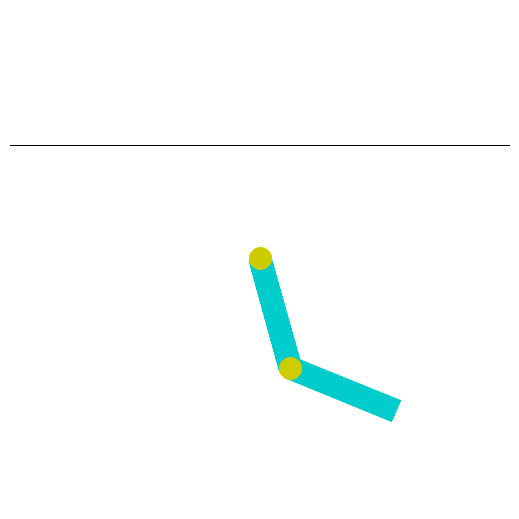

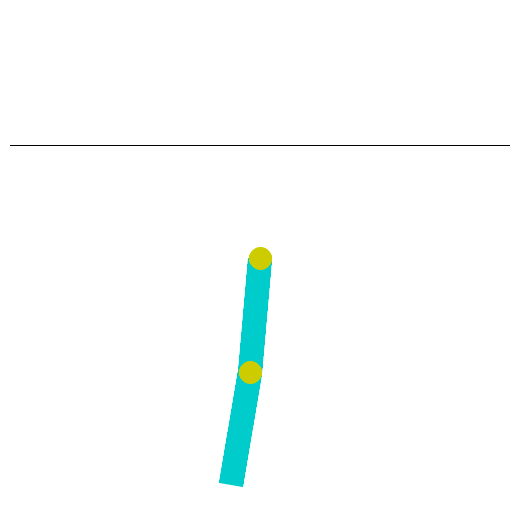

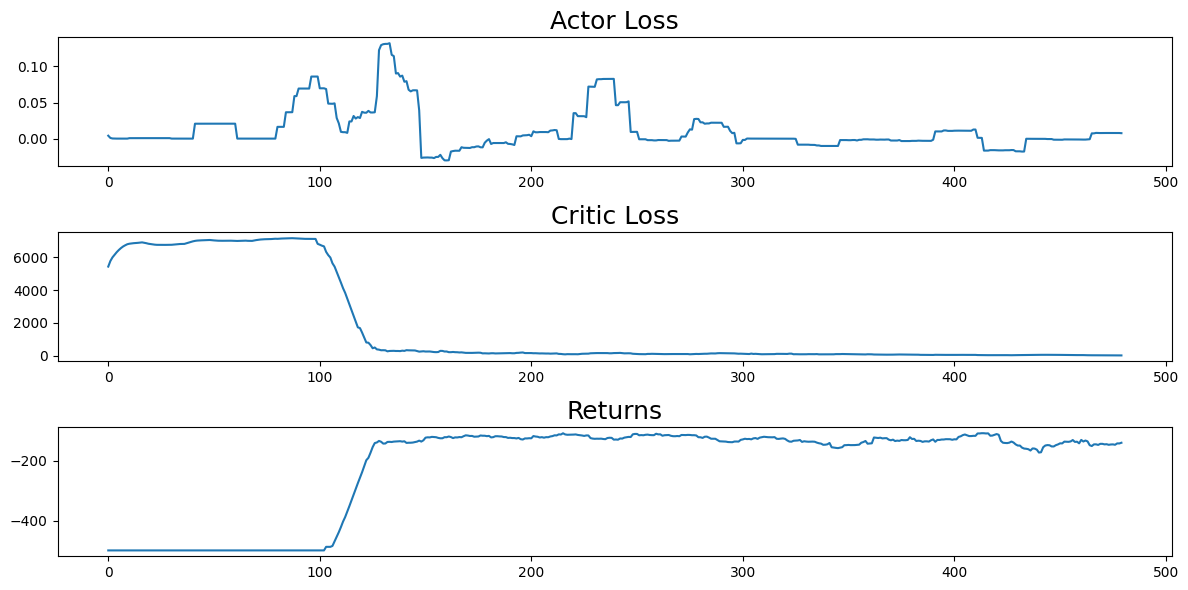

In [71]:
# Show execute stats

plot_stats(stats)

In [72]:
# Test the resulting agent

env = gym.make('Acrobot-v1')

test_policy_network(env, actor, episodes=2)

In [73]:
env.close()